In [6]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

### Load the dataset.

In [62]:
# https://www.tensorflow.org/datasets/splits
train_ds, test_ds = tfds.load(name='genomics_ood', as_supervised=True, split=['train[0:100000]', 'test[0:1000]']);

### Build the TensorFlow dataset: Input pipeline

In [70]:
def onehotify(tensor):
  #print(tensor)
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor) #1231432 => [1,2,3,1,4,3,2]
  labels = tf.cast(tf.strings.to_number(split), tf.uint8) 
  onehot = tf.one_hot(labels, 4) 
  onehot = tf.reshape(onehot, (-1,))
  return onehot

#train_ds_in = tf.data.Dataset.from_tensor_slices(train_ds)
train_ds_in = train_ds;
#train_ds_in = tfds.as_numpy(train_ds);
#print(type(train_ds_in));
#print(train_ds_in);

def onehotify_input(t1, t2):
  return onehotify(t1);

def onehotify_label(t1, t2):
  return tf.one_hotify(t2, depth=10);

def onehotify_all(input,label):
  return (onehotify(input), tf.one_hot(label, depth=10))

def process_ds(train_ds):  
  # train_ds
  # [(cacctacgtagt, 6), (cactagaaca, 7)]
  train_ds_in = train_ds.map(onehotify_all);
  # [('10010010...','0000010000'), (...,...)]
  # 
  
  

  # train_ds_data = [];
  # train_ds_targets = [];

  # for elem in train_ds_in:
  #   train_ds_data.append(elem[0]);
  #   train_ds_targets.append(elem[1]);

  

  # train_ds_data = tf.data.Dataset.from_tensor_slices(train_ds_data);
  # train_ds_targets = tf.data.Dataset.from_tensor_slices(train_ds_targets);

  # train_dataset = tf.data.Dataset.zip((train_ds_data, train_ds_targets))
  train_dataset = train_ds_in;
  train_dataset = train_dataset.batch(128)
  train_dataset = train_dataset.shuffle(buffer_size=128)

  return train_dataset;

  


# zip together input and labels

train_dataset = process_ds(train_ds);
# iterator1 = iter(train_ds_data);
# iterator2 = iter(train_ds_targets);
# print(iterator1.get_next().numpy());
# print(iterator2.get_next().numpy());
# piss();
test_dataset = process_ds(test_ds);



### Build the model.

In [64]:
# We will implement a simple fully connected feed forward neural network like the last time.
#
# Our network will have the following layers:
# Input : 1000 = 250*4 units.
# Hidden layer 1: 256 units. With sigmoid activation function.
# Hidden layer 2: 256 units. With sigmoid activation function.
# Output: 10 units. With softmax activation function.
# 
# Instead of implementing our own layer we can directly implement the network using pre-built layers 
# from TensorFlow.
# For that check out 'tf.keras.layers.Dense(units= , activation=)'. It is basically the same layer that we
# implemented by hand last time.
# For activations functions check out 'tf.keras.activations'.

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

### Train the model.

In [65]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  



In [66]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0;

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average/len(train_dataset))

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


### Visualize the training progress.

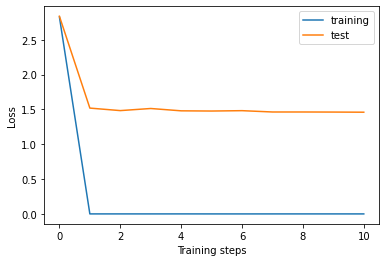

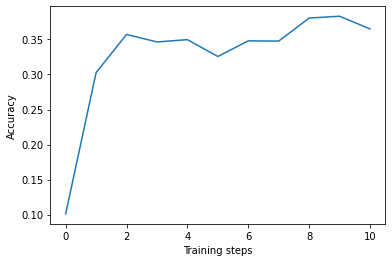

In [75]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
x = list(range(num_epochs+1));
line1, = plt.plot(x, train_losses, label='training')
line2, = plt.plot(x, test_losses, label='test')
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()


## Saving Model
Now that we have seen that our model performs pretty well, we might want to save all the parameters that it has learnt now and use it again later. For subclassed models you will need to use the function **save_weights()** and store it in a .h5 or .hdf5 format. 

In [ ]:
model.save_weights('mnist_mlp.h5')

The next time we can load it again. You will first have to create the new model and call it, so it can create the variables, before you can insert weights into them.

In [ ]:
new_model = model.load_weights('mnist_mlp.h5')